<a href="https://www.kaggle.com/code/dataranch/car-sales-28-models-feature-importance?scriptVersionId=106921293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Car Sales Dataset Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.


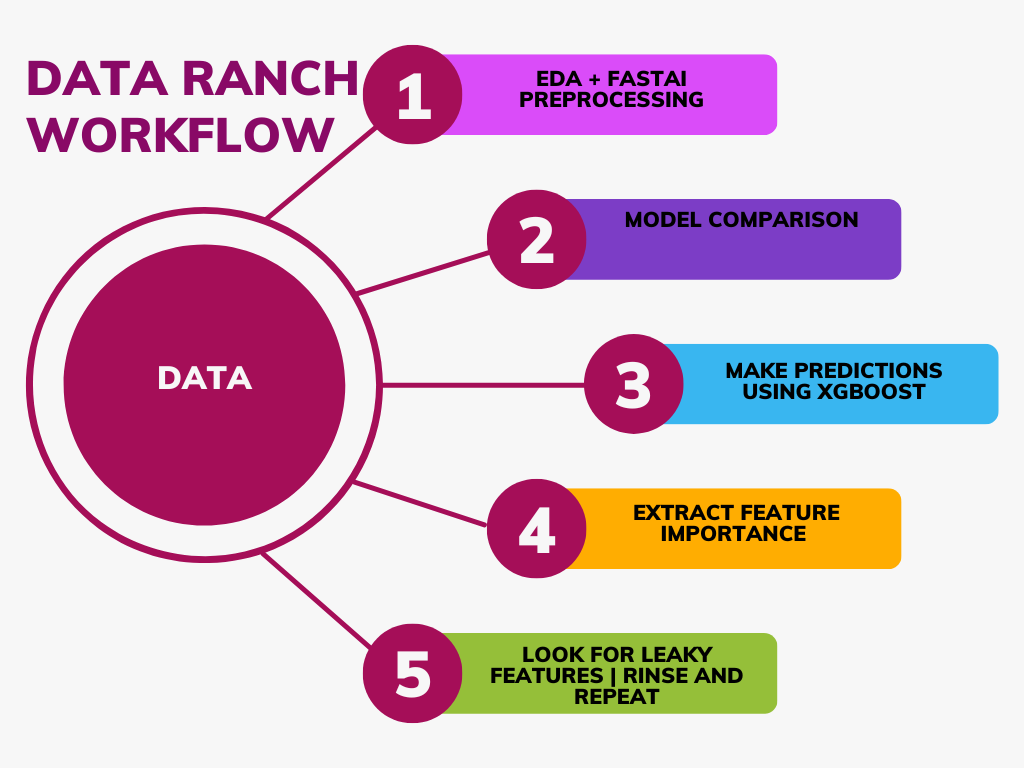

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 581.7 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'car-sales-information'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 10000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [10]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/car-sales-information
CSV!
CSV!
CSV!
CSV!


In [11]:
df

,brand,name,bodyType,color,fuelType,year,mileage,transmission,power,price,vehicleConfiguration,engineName,engineDisplacement,date,location,link,parse_date
0,Fiat,124 Spider,open,blue,Gasoline,NaN,8000.00,Automatic,NaN,1830000,NaN,NaN,NaN,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/fiat/124_spider/47958694.html,2022-08-20 04:00:00
1,BMW,i3,hatchback 5 doors,black,Electro,NaN,12000.00,Automatic,NaN,1830000,NaN,NaN,NaN,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/bmw/i3/47958301.html,2022-08-20 04:00:00
2,Mercedes-Benz,GLE Coupe,jeep 5 doors,burgundy,Gasoline,2015.00,57000.00,AT,367.00,4600000,450 AMG 4MATIC Особая серия,M 276 DE 30 AL,3.0 LTR,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/mercedes-benz/gle_coupe/47684682.html,2022-08-20 04:00:00
3,Mercedes-Benz,G-Class,jeep 5 doors,black,Gasoline,2002.00,200000.00,AT,296.00,2999999,G 500,M 113 E 50,5.0 LTR,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/mercedes-benz/g-class/47056770.html,2022-08-20 04:00:00
4,Audi,Q7,jeep 5 doors,white,Gasoline,NaN,67000.00,Automatic,252.00,3300000,NaN,NaN,NaN,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/audi/q7/46498184.html,2022-08-20 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Subaru,Impreza,hatchback 5 doors,white,Gasoline,NaN,40000.00,CVT,115.00,1245000,NaN,NaN,NaN,2022-08-19 00:00:00,Vladivostok,https://vladivostok.drom.ru/subaru/impreza/46859066.html,2022-08-20 08:00:00
9996,Toyota,Harrier,jeep 5 doors,black,Gasoline,NaN,180000.00,AT,160.00,1390000,NaN,NaN,NaN,2022-08-19 00:00:00,Ussurijsk,https://ussuriisk.drom.ru/toyota/harrier/47739489.html,2022-08-20 08:00:00
9997,Daihatsu,Boon,hatchback 5 doors,white,Gasoline,2010.00,NaN,CVT,69.00,379000,1.0 CL limited,1KR-FE,1.0 LTR,2022-08-19 00:00:00,Nahodka,https://nakhodka.drom.ru/daihatsu/boon/40298248.html,2022-08-20 08:00:00
9998,Honda,HR-V,jeep 5 doors,white,Gasoline,2001.00,216000.00,Manual,105.00,500000,1.6 J,D16A,1.6 LTR,2022-08-19 00:00:00,Artem,https://artem.drom.ru/honda/hr-v/46793229.html,2022-08-20 08:00:00


In [12]:
df.isna().sum()

brand                      0
name                       0
bodyType                   0
color                    841
fuelType                  24
year                    2716
mileage                  134
transmission              15
power                    101
price                      0
vehicleConfiguration    2716
engineName              2721
engineDisplacement      2742
date                       0
location                   0
link                       0
parse_date                 0
dtype: int64

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

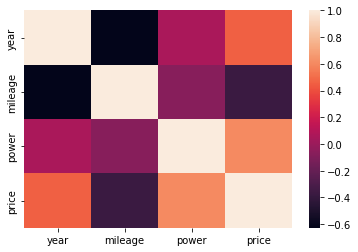

In [14]:
sns.heatmap(df.corr())

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,brand,name,bodyType,color,fuelType,year,mileage,transmission,power,price,vehicleConfiguration,engineName,engineDisplacement,date,location,link,parse_date
0,Fiat,124 Spider,open,blue,Gasoline,nan,8000.00,Automatic,nan,1830000,nan,nan,nan,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/fiat/124_spider/47958694.html,2022-08-20 04:00:00
1,BMW,i3,hatchback 5 doors,black,Electro,nan,12000.00,Automatic,nan,1830000,nan,nan,nan,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/bmw/i3/47958301.html,2022-08-20 04:00:00
2,Mercedes-Benz,GLE Coupe,jeep 5 doors,burgundy,Gasoline,2015.00,57000.00,AT,367.00,4600000,450 AMG 4MATIC Особая серия,M 276 DE 30 AL,3.0 LTR,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/mercedes-benz/gle_coupe/47684682.html,2022-08-20 04:00:00
3,Mercedes-Benz,G-Class,jeep 5 doors,black,Gasoline,2002.00,200000.00,AT,296.00,2999999,G 500,M 113 E 50,5.0 LTR,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/mercedes-benz/g-class/47056770.html,2022-08-20 04:00:00
4,Audi,Q7,jeep 5 doors,white,Gasoline,nan,67000.00,Automatic,252.00,3300000,nan,nan,nan,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/audi/q7/46498184.html,2022-08-20 04:00:00


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
year,7284.00,2010.28,7.57,1948.00,2006.00,2012.00,2016.00,2021.00
mileage,9866.00,131817.86,80185.90,1000.00,72000.00,122000.00,183000.00,500000.00
power,9899.00,145.09,69.61,39.00,99.00,132.00,167.00,612.00
price,10000.00,1349800.41,1528776.90,35000.00,520000.00,870000.00,1651250.00,25000000.00


In [17]:
df.columns

Index(['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage',
       'transmission', 'power', 'price', 'vehicleConfiguration', 'engineName',
       'engineDisplacement', 'date', 'location', 'link', 'parse_date'],
      dtype='object')

Target Variable: price
CATS=====================
['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
CONTS=====================
['vehicleConfiguration', 'link']
16
Could not convert vehicleConfiguration to float.
Could not convert link to float.
Looping through continuous variables to find breakpoint
Error with  vehicleConfiguration
Error with  link
Continuous variables that made the cut : []
Categorical variables that made the cut : ['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
Tabular Object size: 9999


  2%|▏         | 1/42 [00:00<00:20,  1.99it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5704165424536529, 'Adjusted R-Squared': 0.5673852075717735, 'RMSE': 1038323.707017851, 'Time taken': 0.5028283596038818}


 10%|▉         | 4/42 [00:00<00:07,  4.99it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9945414877727092, 'Adjusted R-Squared': 0.9945029700452989, 'RMSE': 117043.18708405233, 'Time taken': 0.2831737995147705}
{'Model': 'BayesianRidge', 'R-Squared': 0.4989538251680343, 'Adjusted R-Squared': 0.4954182170795023, 'RMSE': 1121367.256799396, 'Time taken': 0.05933356285095215}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9981715743172856, 'Adjusted R-Squared': 0.9981586721199278, 'RMSE': 67740.38362962041, 'Time taken': 0.13307571411132812}
{'Model': 'DummyRegressor', 'R-Squared': -0.0016435776887142595, 'Adjusted R-Squared': -0.00871162712805007, 'RMSE': 1585497.6, 'Time taken': 0.017289161682128906}
{'Model': 'ElasticNet', 'R-Squared': 0.44760095734700645, 'Adjusted R-Squared': 0.44370298023151156, 'RMSE': 1177430.9675740271, 'Time taken': 0.030801057815551758}


 17%|█▋        | 7/42 [00:01<00:05,  6.75it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.000251642663945284, 'Adjusted R-Squared': -0.0068030332446760156, 'RMSE': 1583996.964467053, 'Time taken': 0.27765440940856934}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9967728037313511, 'Adjusted R-Squared': 0.9967500311770361, 'RMSE': 89995.68454441751, 'Time taken': 0.055521249771118164}


 21%|██▏       | 9/42 [00:03<00:13,  2.36it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9981126274710017, 'Adjusted R-Squared': 0.9980993093180753, 'RMSE': 68823.66724596715, 'Time taken': 1.794785737991333}
{'Model': 'GammaRegressor', 'R-Squared': 0.39116429756101134, 'Adjusted R-Squared': 0.38686807788654265, 'RMSE': 1236115.4972958744, 'Time taken': 0.0398409366607666}


 26%|██▌       | 11/42 [00:18<01:28,  2.87s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.679345312671151, 'Adjusted R-Squared': -5.7264777896758865, 'RMSE': 4094264.9508631905, 'Time taken': 15.396742820739746}


 29%|██▊       | 12/42 [00:19<01:15,  2.50s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9272217025027012, 'Adjusted R-Squared': 0.926708145967942, 'RMSE': 427375.81434021477, 'Time taken': 0.9638900756835938}


 33%|███▎      | 14/42 [00:20<00:45,  1.61s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9715489171142873, 'Adjusted R-Squared': 0.9713481534245695, 'RMSE': 267213.5001721752, 'Time taken': 0.562932014465332}
{'Model': 'HuberRegressor', 'R-Squared': 0.4553293446550829, 'Adjusted R-Squared': 0.4514859025306732, 'RMSE': 1169165.4803216152, 'Time taken': 0.09675979614257812}


 36%|███▌      | 15/42 [00:20<00:35,  1.30s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8480299429695868, 'Adjusted R-Squared': 0.8469575736155415, 'RMSE': 617572.56, 'Time taken': 0.361863374710083}


 43%|████▎     | 18/42 [00:26<00:33,  1.39s/it]

{'Model': 'KernelRidge', 'R-Squared': -0.2353223835282221, 'Adjusted R-Squared': -0.24403937615392524, 'RMSE': 1760755.8935842544, 'Time taken': 5.377100467681885}
{'Model': 'Lars', 'R-Squared': 0.49902553187327314, 'Adjusted R-Squared': 0.495490429779637, 'RMSE': 1121287.0122705225, 'Time taken': 0.051459312438964844}
{'Model': 'LarsCV', 'R-Squared': 0.49896167474019815, 'Adjusted R-Squared': 0.49542612204179226, 'RMSE': 1121358.4728907247, 'Time taken': 0.11718368530273438}
{'Model': 'Lasso', 'R-Squared': 0.4990255144086323, 'Adjusted R-Squared': 0.4954904121917577, 'RMSE': 1121287.031815306, 'Time taken': 0.05473589897155762}


 52%|█████▏    | 22/42 [00:26<00:12,  1.58it/s]

{'Model': 'LassoCV', 'R-Squared': 0.4989692928641105, 'Adjusted R-Squared': 0.49543379392262743, 'RMSE': 1121349.9479138535, 'Time taken': 0.29126930236816406}
{'Model': 'LassoLars', 'R-Squared': 0.4990237800110848, 'Adjusted R-Squared': 0.49548866555551785, 'RMSE': 1121288.9727882005, 'Time taken': 0.07838773727416992}
{'Model': 'LassoLarsCV', 'R-Squared': 0.49896167474019815, 'Adjusted R-Squared': 0.49542612204179226, 'RMSE': 1121358.4728907247, 'Time taken': 0.10714340209960938}


 57%|█████▋    | 24/42 [00:26<00:07,  2.25it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.4989455305208107, 'Adjusted R-Squared': 0.4954098639015019, 'RMSE': 1121376.5386857525, 'Time taken': 0.06304240226745605}
{'Model': 'LinearRegression', 'R-Squared': 0.49902553187327314, 'Adjusted R-Squared': 0.495490429779637, 'RMSE': 1121287.0122705225, 'Time taken': 0.06151533126831055}
{'Model': 'LinearSVR', 'R-Squared': -0.773476086395684, 'Adjusted R-Squared': -0.7859905345859761, 'RMSE': 2109704.667813315, 'Time taken': 0.06762552261352539}


 62%|██████▏   | 26/42 [00:41<00:41,  2.62s/it]

{'Model': 'MLPRegressor', 'R-Squared': -0.7432598840008149, 'Adjusted R-Squared': -0.7555611130209821, 'RMSE': 2091655.0502535217, 'Time taken': 14.249522686004639}


 69%|██████▉   | 29/42 [00:44<00:24,  1.85s/it]

{'Model': 'NuSVR', 'R-Squared': -0.0410205468942304, 'Adjusted R-Squared': -0.04836645801142758, 'RMSE': 1616362.0530410889, 'Time taken': 3.641709327697754}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2901894012983304, 'Adjusted R-Squared': 0.2851806571542661, 'RMSE': 1334689.4735604515, 'Time taken': 0.03393435478210449}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4758247229623964, 'Adjusted R-Squared': 0.47212590548330047, 'RMSE': 1146957.332189587, 'Time taken': 0.06577873229980469}


 74%|███████▍  | 31/42 [00:46<00:15,  1.42s/it]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.449556455960867, 'Adjusted R-Squared': 0.4456722777267199, 'RMSE': 1175345.0606940065, 'Time taken': 1.0714905261993408}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6432954693478148, 'Adjusted R-Squared': 0.6407784010871642, 'RMSE': 946157.2208128882, 'Time taken': 0.07286500930786133}


 76%|███████▌  | 32/42 [3:25:41<6:33:45, 2362.58s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.11292651665877962, 'Adjusted R-Squared': -0.1207798287722992, 'RMSE': 1671253.1560297802, 'Time taken': 12295.931729793549}


 79%|███████▊  | 33/42 [3:25:42<4:38:06, 1854.03s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.22104145276936882, 'Adjusted R-Squared': 0.21554476947237844, 'RMSE': 1398189.9266009654, 'Time taken': 0.40775251388549805}


 88%|████████▊ | 37/42 [3:25:45<58:52, 706.48s/it]   

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9972826673035148, 'Adjusted R-Squared': 0.9972634925768259, 'RMSE': 82581.05039628148, 'Time taken': 2.8554482460021973}
{'Model': 'Ridge', 'R-Squared': 0.4990214294511812, 'Adjusted R-Squared': 0.49548629840900205, 'RMSE': 1121291.6033060804, 'Time taken': 0.025115489959716797}
{'Model': 'RidgeCV', 'R-Squared': 0.4989837584141137, 'Adjusted R-Squared': 0.49544836154808425, 'RMSE': 1121333.7602225658, 'Time taken': 0.04686164855957031}
{'Model': 'SGDRegressor', 'R-Squared': 0.4959605848222569, 'Adjusted R-Squared': 0.49240385507805917, 'RMSE': 1124711.782566207, 'Time taken': 0.06972980499267578}


 90%|█████████ | 38/42 [3:25:51<38:05, 571.28s/it]

{'Model': 'SVR', 'R-Squared': -0.11236112734029646, 'Adjusted R-Squared': -0.1202104498114478, 'RMSE': 1670828.58679387, 'Time taken': 5.719401836395264}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.49902553187327314, 'Adjusted R-Squared': 0.495490429779637, 'RMSE': 1121287.0122705225, 'Time taken': 0.03268146514892578}
{'Model': 'TweedieRegressor', 'R-Squared': 0.3931931963396237, 'Adjusted R-Squared': 0.3889112934912138, 'RMSE': 1234054.1479924254, 'Time taken': 0.05128884315490723}


 98%|█████████▊| 41/42 [3:25:52<05:12, 312.89s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9962043752295612, 'Adjusted R-Squared': 0.9961775915870278, 'RMSE': 97600.19, 'Time taken': 1.0647835731506348}


100%|██████████| 42/42 [3:25:52<00:00, 294.11s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9703556682751537, 'Adjusted R-Squared': 0.9701464844827405, 'RMSE': 272759.46353049355, 'Time taken': 0.2812469005584717}
Project: car-sales-information
car-sales-information
Target: price
price
Target Standard Deviation: 1514316.875
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
DecisionTreeRegressor                        1.00       1.00   67740.38   
ExtraTreesRegressor                          1.00       1.00   68823.67   
RandomForestRegressor                        1.00       1.00   82581.05   
ExtraTreeRegressor                           1.00       1.00   89995.68   
XGBRegressor                                 1.00       1.00   97600.19   
BaggingRegressor                             0.99       0.99  117043.19   
HistGradientBoostingRegressor                0.97       0.97  267213.50   
LGBMRegressor                                0.97

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4120500502528.000000,4472560943104.000000,2114843.250000,00:07
1,4032045776896.000000,4432224321536.000000,2105285.000000,00:08
2,3766637821952.000000,3827062800384.000000,1956288.125000,00:08
3,3054547238912.000000,1538969698304.000000,1240552.125000,00:07
4,2199474929664.000000,1499715469312.000000,1224628.625000,00:07
5,1408876281856.000000,955584610304.000000,977540.125000,00:08
6,875154898944.000000,759754850304.000000,871639.187500,00:07
7,823921606656.000000,858002817024.000000,926284.500000,00:08


Better model found at epoch 0 with _rmse value: 2114843.25.
Better model found at epoch 1 with _rmse value: 2105285.0.
Better model found at epoch 2 with _rmse value: 1956288.125.
Better model found at epoch 3 with _rmse value: 1240552.125.
Better model found at epoch 4 with _rmse value: 1224628.625.
Better model found at epoch 5 with _rmse value: 977540.125.
Better model found at epoch 6 with _rmse value: 871639.1875.
No improvement since epoch 6: early stopping


,brand,name,bodyType,color,fuelType,year,mileage,transmission,power,engineName,engineDisplacement,date,location,parse_date,price,price_pred
0,37.00,235.00,7.00,9.00,4.00,35.00,141.00,4.00,86.00,71.00,12.00,2.00,35.00,5.00,1510000.00,2160973.50
1,13.00,126.00,7.00,1.00,4.00,1.00,101.00,4.00,33.00,1.00,1.00,1.00,35.00,3.00,887000.00,1762319.75
2,35.00,171.00,4.00,3.00,4.00,31.00,91.00,2.00,12.00,199.00,2.00,1.00,35.00,3.00,625000.00,1136040.25
3,29.00,101.00,5.00,12.00,4.00,27.00,221.00,4.00,72.00,243.00,12.00,1.00,21.00,5.00,670000.00,1140859.00
4,37.00,213.00,10.00,15.00,4.00,19.00,198.00,2.00,92.00,7.00,12.00,1.00,2.00,3.00,400000.00,814734.38
5,34.00,194.00,11.00,9.00,4.00,16.00,100.00,2.00,88.00,144.00,12.00,2.00,35.00,4.00,120000.00,969595.81
6,28.00,105.00,5.00,12.00,4.00,40.00,20.00,4.00,84.00,80.00,8.00,2.00,35.00,3.00,3250000.00,2591059.50
7,37.00,320.00,11.00,13.00,4.00,35.00,118.00,4.00,44.00,20.00,8.00,1.00,6.00,5.00,800000.00,1240226.50
8,25.00,40.00,7.00,15.00,4.00,1.00,121.00,5.00,43.00,1.00,1.00,1.00,35.00,3.00,1060000.00,1828260.50


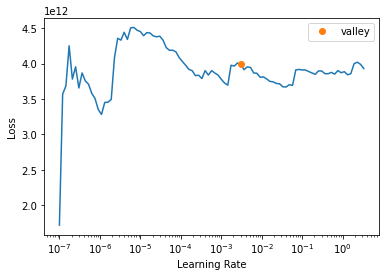

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
      actual  predicted
0 1330000.00 1296012.38
1  980000.00 1002233.06
2  600000.00  580624.69
3 1860000.00 1796305.50
4  389000.00  520830.28
XGBoost RMSE:  97600.19


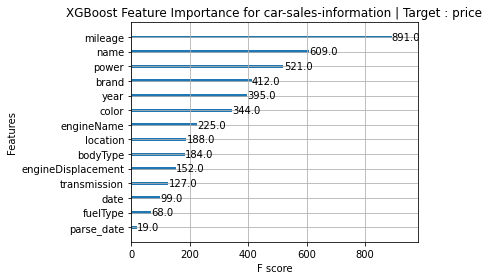

Target Variable: power
CATS=====================
['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
CONTS=====================
['price', 'vehicleConfiguration', 'link']
17
Could not convert vehicleConfiguration to float.
Could not convert link to float.
Looping through continuous variables to find breakpoint
Error with  vehicleConfiguration
Error with  link
Continuous variables that made the cut : ['price']
Categorical variables that made the cut : ['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
Tabular Object size: 9999


  2%|▏         | 1/42 [00:00<00:21,  1.94it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5395952562802688, 'Adjusted R-Squared': 0.5365800111072933, 'RMSE': 26.746217314947213, 'Time taken': 0.5139918327331543}


 10%|▉         | 4/42 [00:00<00:06,  5.45it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9958371505393303, 'Adjusted R-Squared': 0.9958098875453814, 'RMSE': 2.543242820106057, 'Time taken': 0.22423958778381348}
{'Model': 'BayesianRidge', 'R-Squared': 0.4963114383040713, 'Adjusted R-Squared': 0.49301272228288884, 'RMSE': 27.975220505069643, 'Time taken': 0.05049872398376465}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.995733060790099, 'Adjusted R-Squared': 0.9957051161000594, 'RMSE': 2.574842695671665, 'Time taken': 0.1240386962890625}
{'Model': 'DummyRegressor', 'R-Squared': -0.001180345015220352, 'Adjusted R-Squared': -0.0077371936223729065, 'RMSE': 39.44106484135425, 'Time taken': 0.013153791427612305}
{'Model': 'ElasticNet', 'R-Squared': 0.40795806986197647, 'Adjusted R-Squared': 0.4040807171708962, 'RMSE': 30.32974137344776, 'Time taken': 0.024044275283813477}


 17%|█▋        | 7/42 [00:01<00:04,  7.64it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.49551518945446016, 'Adjusted R-Squared': 0.49221125870529536, 'RMSE': 27.99732388642187, 'Time taken': 0.23330354690551758}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.999633287273819, 'Adjusted R-Squared': 0.9996308856287608, 'RMSE': 0.7548409716266222, 'Time taken': 0.0501711368560791}


 21%|██▏       | 9/42 [00:02<00:11,  2.91it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9991094336048298, 'Adjusted R-Squared': 0.9991036011800756, 'RMSE': 1.1763203920838983, 'Time taken': 1.4095458984375}
{'Model': 'GammaRegressor', 'R-Squared': 0.3435098652575256, 'Adjusted R-Squared': 0.33921043364460257, 'RMSE': 31.93791614028263, 'Time taken': 0.042929649353027344}


 26%|██▌       | 11/42 [00:23<01:55,  3.71s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9136764285343995, 'Adjusted R-Squared': 0.9131110852452041, 'RMSE': 11.581296334071622, 'Time taken': 20.74871325492859}


 29%|██▊       | 12/42 [00:24<01:34,  3.16s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8224912235208148, 'Adjusted R-Squared': 0.8213286975287597, 'RMSE': 16.607428424935716, 'Time taken': 0.8449554443359375}


 31%|███       | 13/42 [00:24<01:15,  2.60s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9538848262726638, 'Adjusted R-Squared': 0.9535828125404444, 'RMSE': 8.46475511793106, 'Time taken': 0.5843276977539062}
{'Model': 'HuberRegressor', 'R-Squared': 0.4897090600737385, 'Adjusted R-Squared': 0.4863671042958838, 'RMSE': 28.157973957625398, 'Time taken': 0.0890958309173584}


 36%|███▌      | 15/42 [00:25<00:45,  1.69s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8100124147905097, 'Adjusted R-Squared': 0.8087681636027397, 'RMSE': 17.181262989051458, 'Time taken': 0.3426074981689453}


 43%|████▎     | 18/42 [00:32<00:41,  1.74s/it]

{'Model': 'KernelRidge', 'R-Squared': -2.746012359445096, 'Adjusted R-Squared': -2.7705454378696737, 'RMSE': 76.29166218678863, 'Time taken': 6.683993577957153}
{'Model': 'Lars', 'R-Squared': 0.4963140811007368, 'Adjusted R-Squared': 0.4930153823875426, 'RMSE': 27.97514711357133, 'Time taken': 0.04547381401062012}
{'Model': 'LarsCV', 'R-Squared': 0.4963140811007368, 'Adjusted R-Squared': 0.4930153823875426, 'RMSE': 27.97514711357133, 'Time taken': 0.1034383773803711}
{'Model': 'Lasso', 'R-Squared': 0.4953128860628295, 'Adjusted R-Squared': 0.49200763040480266, 'RMSE': 28.002936925455867, 'Time taken': 0.046534061431884766}


 52%|█████▏    | 22/42 [00:32<00:16,  1.22it/s]

{'Model': 'LassoCV', 'R-Squared': 0.4965213668405034, 'Adjusted R-Squared': 0.4932240256661591, 'RMSE': 27.969390107487836, 'Time taken': 0.2962973117828369}
{'Model': 'LassoLars', 'R-Squared': -0.001180345015220352, 'Adjusted R-Squared': -0.0077371936223729065, 'RMSE': 39.44106484135425, 'Time taken': 0.053169965744018555}
{'Model': 'LassoLarsCV', 'R-Squared': 0.4963140811007368, 'Adjusted R-Squared': 0.4930153823875426, 'RMSE': 27.97514711357133, 'Time taken': 0.08733916282653809}
{'Model': 'LassoLarsIC', 'R-Squared': 0.496620462022348, 'Adjusted R-Squared': 0.4933237698340812, 'RMSE': 27.966637489989782, 'Time taken': 0.04662060737609863}


 60%|█████▉    | 25/42 [00:32<00:08,  2.02it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.4963140811007368, 'Adjusted R-Squared': 0.4930153823875426, 'RMSE': 27.97514711357133, 'Time taken': 0.03488636016845703}
{'Model': 'LinearSVR', 'R-Squared': 0.4748490630712794, 'Adjusted R-Squared': 0.4714097874138117, 'RMSE': 28.56502091920102, 'Time taken': 0.056767940521240234}


 62%|██████▏   | 26/42 [00:48<00:49,  3.08s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.7521113491144815, 'Adjusted R-Squared': 0.7504878969928132, 'RMSE': 19.625502980281407, 'Time taken': 16.061490058898926}


 71%|███████▏  | 30/42 [00:52<00:21,  1.77s/it]

{'Model': 'NuSVR', 'R-Squared': 0.5890535717208707, 'Adjusted R-Squared': 0.5863622349109822, 'RMSE': 25.26882683239738, 'Time taken': 3.665769577026367}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3763771151652683, 'Adjusted R-Squared': 0.37229293506307604, 'RMSE': 31.128163296781338, 'Time taken': 0.02525496482849121}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.48506537191933985, 'Adjusted R-Squared': 0.4816930040780055, 'RMSE': 28.285803702725147, 'Time taken': 0.0633702278137207}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.41687386116393954, 'Adjusted R-Squared': 0.41305489904561765, 'RMSE': 30.100501318474993, 'Time taken': 0.04734206199645996}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4333096915649802, 'Adjusted R-Squared': 0.42959836964575837, 'RMSE': 29.67326716597988, 'Time taken': 0.05859231948852539}


 76%|███████▌  | 32/42 [2:04:59<3:06:36, 1119.62s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.004060410160586558, 'Adjusted R-Squared': -0.010636120655341141, 'RMSE': 39.497753559692505, 'Time taken': 7446.523787975311}


 79%|███████▊  | 33/42 [2:04:59<2:18:17, 921.91s/it] 

{'Model': 'RANSACRegressor', 'R-Squared': 0.26732080933693236, 'Adjusted R-Squared': 0.2625224065769223, 'RMSE': 33.74033595882753, 'Time taken': 0.384274959564209}


 86%|████████▌ | 36/42 [2:05:01<46:44, 467.47s/it]  

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9971820237442435, 'Adjusted R-Squared': 0.9971635684841302, 'RMSE': 2.092479147922924, 'Time taken': 2.1979799270629883}
{'Model': 'Ridge', 'R-Squared': 0.4963139610719657, 'Adjusted R-Squared': 0.4930152615726888, 'RMSE': 27.975150446821484, 'Time taken': 0.028258323669433594}
{'Model': 'RidgeCV', 'R-Squared': 0.4963104463713651, 'Adjusted R-Squared': 0.4930117238538979, 'RMSE': 27.975248051379634, 'Time taken': 0.072021484375}
{'Model': 'SGDRegressor', 'R-Squared': 0.4952260696771894, 'Adjusted R-Squared': 0.491920245448375, 'RMSE': 28.0053453574951, 'Time taken': 0.10039377212524414}


 90%|█████████ | 38/42 [2:05:07<20:32, 308.08s/it]

{'Model': 'SVR', 'R-Squared': 0.6052741937932096, 'Adjusted R-Squared': 0.6026890877575983, 'RMSE': 24.765108460036352, 'Time taken': 5.296512126922607}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4963140811007368, 'Adjusted R-Squared': 0.4930153823875426, 'RMSE': 27.97514711357133, 'Time taken': 0.035684823989868164}
{'Model': 'TweedieRegressor', 'R-Squared': 0.34986349978419573, 'Adjusted R-Squared': 0.34560567887598137, 'RMSE': 31.782989809170108, 'Time taken': 0.04349517822265625}


 98%|█████████▊| 41/42 [2:05:08<02:57, 177.74s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9919817619221242, 'Adjusted R-Squared': 0.9919292495316897, 'RMSE': 3.5296526, 'Time taken': 1.052454948425293}


100%|██████████| 42/42 [2:05:08<00:00, 178.78s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9557269183641651, 'Adjusted R-Squared': 0.9554369687111345, 'RMSE': 8.293967900378641, 'Time taken': 0.23927545547485352}
Project: car-sales-information
car-sales-information
Target: power
power
Target Standard Deviation: 40.74809865502929
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreeRegressor                           1.00       1.00  0.75        0.05
ExtraTreesRegressor                          1.00       1.00  1.18        1.41
RandomForestRegressor                        1.00       1.00  2.09        2.20
BaggingRegressor                             1.00       1.00  2.54        0.22
DecisionTreeRegressor                        1.00       1.00  2.57        0.12
XGBRegressor                                 0.99       0.99  3.53        1.05
LGBMRegressor                                0.96       0.96  8.29        0.24
HistGra

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2246.964600,2569.717529,50.692383,00:07
1,1489.690186,1381.868286,37.173492,00:08
2,847.273376,695.696716,26.376064,00:08
3,555.707886,629.785095,25.095518,00:08
4,479.909790,572.136536,23.919376,00:08
5,392.808289,311.254364,17.642403,00:08
6,304.265015,323.719666,17.992210,00:07


Better model found at epoch 0 with _rmse value: 50.6923828125.
Better model found at epoch 1 with _rmse value: 37.173492431640625.
Better model found at epoch 2 with _rmse value: 26.37606430053711.
Better model found at epoch 3 with _rmse value: 25.095518112182617.
Better model found at epoch 4 with _rmse value: 23.919376373291016.
Better model found at epoch 5 with _rmse value: 17.64240264892578.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0     132     130.15
1      71      70.65
2      66      66.11
3      74      76.03
4      15      15.43
XGBoost RMSE:  3.5217137


<Figure size 432x288 with 0 Axes>

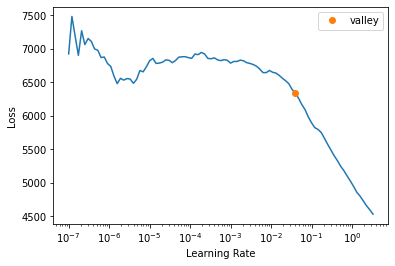

<Figure size 720x720 with 0 Axes>

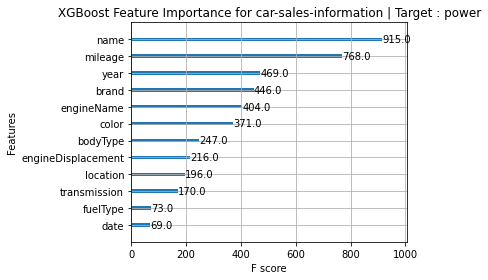

Target Variable: mileage
CATS=====================
['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
CONTS=====================
['price', 'vehicleConfiguration', 'link']
17
Could not convert vehicleConfiguration to float.
Could not convert link to float.
Looping through continuous variables to find breakpoint
Error with  vehicleConfiguration
Error with  link
Continuous variables that made the cut : ['price']
Categorical variables that made the cut : ['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
Tabular Object size: 9999


  2%|▏         | 1/42 [00:00<00:08,  5.09it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3486816030583211, 'Adjusted R-Squared': 0.3444160417685267, 'RMSE': 60.44386492003267, 'Time taken': 0.1963040828704834}


 10%|▉         | 4/42 [00:00<00:05,  7.32it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9449099051208889, 'Adjusted R-Squared': 0.9445491135675245, 'RMSE': 17.578925025407827, 'Time taken': 0.2589550018310547}
{'Model': 'BayesianRidge', 'R-Squared': 0.28734250894911717, 'Adjusted R-Squared': 0.2826752306701945, 'RMSE': 63.22603988707693, 'Time taken': 0.05356860160827637}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9382673269923912, 'Adjusted R-Squared': 0.9378630324084624, 'RMSE': 18.608574041211675, 'Time taken': 0.1019899845123291}
{'Model': 'DummyRegressor', 'R-Squared': -0.00032823089876776734, 'Adjusted R-Squared': -0.006879498909691861, 'RMSE': 74.90776104716414, 'Time taken': 0.02174687385559082}
{'Model': 'ElasticNet', 'R-Squared': 0.2136374230035364, 'Adjusted R-Squared': 0.20848744139096498, 'RMSE': 66.41512162740753, 'Time taken': 0.033052921295166016}


 17%|█▋        | 7/42 [00:00<00:03,  8.79it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.28492652422044806, 'Adjusted R-Squared': 0.28024342337151387, 'RMSE': 63.333120711571254, 'Time taken': 0.2317206859588623}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.942162034332573, 'Adjusted R-Squared': 0.9417832466481011, 'RMSE': 18.012004975708724, 'Time taken': 0.05393242835998535}


 21%|██▏       | 9/42 [00:02<00:12,  2.68it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9464883020389091, 'Adjusted R-Squared': 0.9461378475938239, 'RMSE': 17.325266332229138, 'Time taken': 1.6396560668945312}
{'Model': 'GammaRegressor', 'R-Squared': 0.18033655609804244, 'Adjusted R-Squared': 0.17496848316568703, 'RMSE': 67.80681369006517, 'Time taken': 0.03891491889953613}


 26%|██▌       | 11/42 [00:26<02:13,  4.32s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.7076013869456235, 'Adjusted R-Squared': -3.738432025751817, 'RMSE': 162.5007593595677, 'Time taken': 24.237175226211548}


 29%|██▊       | 12/42 [00:27<01:49,  3.65s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5349466551148997, 'Adjusted R-Squared': 0.531900965702554, 'RMSE': 51.07483118828515, 'Time taken': 0.8441729545593262}


 31%|███       | 13/42 [00:28<01:26,  3.00s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.755649112327851, 'Adjusted R-Squared': 0.7540488294362954, 'RMSE': 37.022224859057076, 'Time taken': 0.6429135799407959}
{'Model': 'HuberRegressor', 'R-Squared': 0.2867646751874212, 'Adjusted R-Squared': 0.28209361260678467, 'RMSE': 63.25166702094728, 'Time taken': 0.07809662818908691}


 36%|███▌      | 15/42 [00:28<00:52,  1.93s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5895133468057323, 'Adjusted R-Squared': 0.5868250211173063, 'RMSE': 47.9849530359146, 'Time taken': 0.3124556541442871}


 43%|████▎     | 18/42 [00:35<00:45,  1.90s/it]

{'Model': 'KernelRidge', 'R-Squared': -2.6566538511458844, 'Adjusted R-Squared': -2.6806017101206434, 'RMSE': 143.21795859941403, 'Time taken': 7.049486398696899}
{'Model': 'Lars', 'R-Squared': 0.28742069352436095, 'Adjusted R-Squared': 0.28275392728547766, 'RMSE': 63.222571575354294, 'Time taken': 0.03797769546508789}
{'Model': 'LarsCV', 'R-Squared': 0.28733622986999363, 'Adjusted R-Squared': 0.2826689104686384, 'RMSE': 63.226318422304324, 'Time taken': 0.09490966796875}
{'Model': 'Lasso', 'R-Squared': 0.2814109182982709, 'Adjusted R-Squared': 0.27670479332994724, 'RMSE': 63.48861613029198, 'Time taken': 0.031067609786987305}


 52%|█████▏    | 22/42 [00:36<00:17,  1.13it/s]

{'Model': 'LassoCV', 'R-Squared': 0.28729119675276127, 'Adjusted R-Squared': 0.28262358242418983, 'RMSE': 63.22831602155847, 'Time taken': 0.28423094749450684}
{'Model': 'LassoLars', 'R-Squared': -0.00032823089876776734, 'Adjusted R-Squared': -0.006879498909691861, 'RMSE': 74.90776104716414, 'Time taken': 0.06651163101196289}
{'Model': 'LassoLarsCV', 'R-Squared': 0.28733622986999363, 'Adjusted R-Squared': 0.2826689104686384, 'RMSE': 63.226318422304324, 'Time taken': 0.1087799072265625}


 60%|█████▉    | 25/42 [00:36<00:09,  1.87it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.28742069352436095, 'Adjusted R-Squared': 0.28275392728547766, 'RMSE': 63.222571575354294, 'Time taken': 0.051503658294677734}
{'Model': 'LinearRegression', 'R-Squared': 0.28742069352436095, 'Adjusted R-Squared': 0.28275392728547766, 'RMSE': 63.222571575354294, 'Time taken': 0.030704975128173828}
{'Model': 'LinearSVR', 'R-Squared': 0.2805877265388679, 'Adjusted R-Squared': 0.2758762103902559, 'RMSE': 63.52497094539819, 'Time taken': 0.044129133224487305}
{'Model': 'MLPRegressor', 'R-Squared': 0.45651090826696583, 'Adjusted R-Squared': 0.45295153386266884, 'RMSE': 55.214223594574946, 'Time taken': 15.236172437667847}


 71%|███████▏  | 30/42 [00:55<00:23,  1.93s/it]

{'Model': 'NuSVR', 'R-Squared': 0.26333792511466236, 'Adjusted R-Squared': 0.25851343797435533, 'RMSE': 64.28204872489297, 'Time taken': 3.6365513801574707}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.1401526690923608, 'Adjusted R-Squared': 0.13452142712671877, 'RMSE': 69.44903690002734, 'Time taken': 0.023334980010986328}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.26432954665309105, 'Adjusted R-Squared': 0.2595115537596352, 'RMSE': 64.23876909101566, 'Time taken': 0.06518673896789551}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.08623361707310295, 'Adjusted R-Squared': 0.0802492528524229, 'RMSE': 71.59342542285499, 'Time taken': 0.061423540115356445}
{'Model': 'PoissonRegressor', 'R-Squared': 0.27074176719559473, 'Adjusted R-Squared': 0.2659657686936011, 'RMSE': 63.9581987206955, 'Time taken': 0.06647539138793945}


 76%|███████▌  | 32/42 [2:05:06<2:44:49, 988.91s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.01150679663912979, 'Adjusted R-Squared': -0.018131274400494446, 'RMSE': 75.32514152747311, 'Time taken': 7450.405847072601}


 79%|███████▊  | 33/42 [2:05:06<2:04:43, 831.55s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.16901452769154934, 'Adjusted R-Squared': -0.1766705422305872, 'RMSE': 80.97771313679496, 'Time taken': 0.41722536087036133}


 88%|████████▊ | 37/42 [2:05:09<32:56, 395.38s/it]  

{'Model': 'RandomForestRegressor', 'R-Squared': 0.953223999610552, 'Adjusted R-Squared': 0.9529176580462887, 'RMSE': 16.198212643923817, 'Time taken': 2.4357516765594482}
{'Model': 'Ridge', 'R-Squared': 0.2874164360293213, 'Adjusted R-Squared': 0.282749641907599, 'RMSE': 63.22276044512667, 'Time taken': 0.024970054626464844}
{'Model': 'RidgeCV', 'R-Squared': 0.287374959141415, 'Adjusted R-Squared': 0.28270789338264335, 'RMSE': 63.22460040139525, 'Time taken': 0.04474306106567383}
{'Model': 'SGDRegressor', 'R-Squared': 0.2852789275535733, 'Adjusted R-Squared': 0.2805981346357881, 'RMSE': 63.317512837650355, 'Time taken': 0.07836699485778809}


 93%|█████████▎| 39/42 [2:05:14<13:45, 275.20s/it]

{'Model': 'SVR', 'R-Squared': 0.28976720915152077, 'Adjusted R-Squared': 0.28511581052127877, 'RMSE': 63.11839012963333, 'Time taken': 5.386810541152954}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.28742069352436095, 'Adjusted R-Squared': 0.28275392728547766, 'RMSE': 63.222571575354294, 'Time taken': 0.024107933044433594}
{'Model': 'TweedieRegressor', 'R-Squared': 0.1816996815415789, 'Adjusted R-Squared': 0.1763405358791308, 'RMSE': 67.75040782384872, 'Time taken': 0.046846866607666016}


 98%|█████████▊| 41/42 [2:05:15<03:11, 191.64s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9072990983887287, 'Adjusted R-Squared': 0.9066919892094105, 'RMSE': 22.803291, 'Time taken': 1.054244041442871}


100%|██████████| 42/42 [2:05:15<00:00, 178.95s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7659718346981809, 'Adjusted R-Squared': 0.764439156537514, 'RMSE': 36.23177557976166, 'Time taken': 0.2274308204650879}
Project: car-sales-information
car-sales-information
Target: mileage
mileage
Target Standard Deviation: 74.215127344325
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
RandomForestRegressor                        0.95       0.95  16.20   
ExtraTreesRegressor                          0.95       0.95  17.33   
BaggingRegressor                             0.94       0.94  17.58   
ExtraTreeRegressor                           0.94       0.94  18.01   
DecisionTreeRegressor                        0.94       0.94  18.61   
XGBRegressor                                 0.91       0.91  22.80   
LGBMRegressor                                0.76       0.77  36.23   
HistGradientBoostingRegressor                0.75       0.76  37.02   
KNeighbo

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,9349.567383,6993.942383,83.629791,00:08
1,5660.394531,5798.536621,76.148132,00:08
2,3741.046631,2254.881592,47.485600,00:08
3,1055.601929,2005.053223,44.777817,00:08
4,434.011993,1192.190308,34.528111,00:08
5,291.421692,186.722137,13.664630,00:08
6,238.826401,313.091400,17.694389,00:08


Better model found at epoch 0 with _rmse value: 83.62979125976562.
Better model found at epoch 1 with _rmse value: 76.14813232421875.
Better model found at epoch 2 with _rmse value: 47.485599517822266.
Better model found at epoch 3 with _rmse value: 44.77781677246094.
Better model found at epoch 4 with _rmse value: 34.52811050415039.
Better model found at epoch 5 with _rmse value: 13.664629936218262.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0     232     208.55
1      61      62.21
2     101      51.35
3      92      99.54
4     195     193.23
XGBoost RMSE:  22.803291


<Figure size 432x288 with 0 Axes>

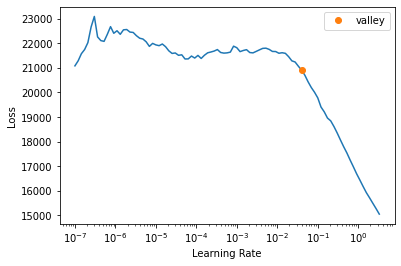

<Figure size 720x720 with 0 Axes>

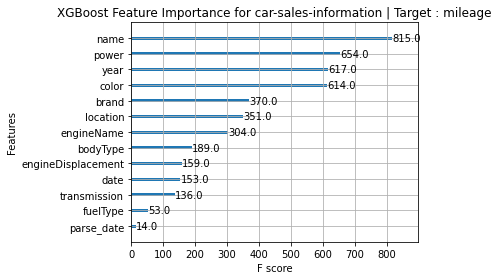

Target Variable: year
CATS=====================
['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
CONTS=====================
['price', 'vehicleConfiguration', 'link']
17
Could not convert vehicleConfiguration to float.
Could not convert link to float.
Looping through continuous variables to find breakpoint
Error with  vehicleConfiguration
Error with  link
Continuous variables that made the cut : ['price']
Categorical variables that made the cut : ['brand', 'name', 'bodyType', 'color', 'fuelType', 'year', 'mileage', 'transmission', 'power', 'engineName', 'engineDisplacement', 'date', 'location', 'parse_date']
Tabular Object size: 9999


  2%|▏         | 1/42 [00:00<00:23,  1.74it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8863993042476763, 'Adjusted R-Squared': 0.8856553198422454, 'RMSE': 4.809127652608425, 'Time taken': 0.5738222599029541}


 10%|▉         | 4/42 [00:00<00:06,  5.68it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9983235940445611, 'Adjusted R-Squared': 0.9983126150634927, 'RMSE': 0.5842051847158877, 'Time taken': 0.23175740242004395}
{'Model': 'BayesianRidge', 'R-Squared': 0.6572124899917071, 'Adjusted R-Squared': 0.6549675340067661, 'RMSE': 8.3538813772902, 'Time taken': 0.04203915596008301}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.999498736878295, 'Adjusted R-Squared': 0.9994954540467675, 'RMSE': 0.31945426200436955, 'Time taken': 0.0732564926147461}
{'Model': 'DummyRegressor', 'R-Squared': -0.001114096490664629, 'Adjusted R-Squared': -0.0076705112283870225, 'RMSE': 14.276363515520796, 'Time taken': 0.02565312385559082}
{'Model': 'ElasticNet', 'R-Squared': 0.5367228525278054, 'Adjusted R-Squared': 0.5336887956425971, 'RMSE': 9.711722139301191, 'Time taken': 0.03078913688659668}


 17%|█▋        | 7/42 [00:01<00:04,  7.01it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6569493562516343, 'Adjusted R-Squared': 0.6547026769726778, 'RMSE': 8.357087104307961, 'Time taken': 0.2943868637084961}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9993267348267295, 'Adjusted R-Squared': 0.9993223255334033, 'RMSE': 0.37022767895868286, 'Time taken': 0.09089827537536621}


 21%|██▏       | 9/42 [00:02<00:11,  2.97it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9996449826055074, 'Adjusted R-Squared': 0.999642657554561, 'RMSE': 0.26884417158327456, 'Time taken': 1.2902312278747559}
{'Model': 'GammaRegressor', 'R-Squared': 0.46117738730978786, 'Adjusted R-Squared': 0.457648574229197, 'RMSE': 10.473665898551904, 'Time taken': 0.04449868202209473}


 26%|██▌       | 11/42 [00:25<02:03,  3.99s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.834764292113821, 'Adjusted R-Squared': -6.88607509100424, 'RMSE': 39.93822663302377, 'Time taken': 22.418588876724243}


 29%|██▊       | 12/42 [00:26<01:42,  3.40s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9551175517433229, 'Adjusted R-Squared': 0.9548236112761507, 'RMSE': 3.0228324720807445, 'Time taken': 0.9322266578674316}


 31%|███       | 13/42 [00:26<01:21,  2.81s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9872051404369746, 'Adjusted R-Squared': 0.9871213453869396, 'RMSE': 1.6139629881865611, 'Time taken': 0.6866390705108643}
{'Model': 'HuberRegressor', 'R-Squared': 0.6525596434502919, 'Adjusted R-Squared': 0.6502842154225105, 'RMSE': 8.410386232057425, 'Time taken': 0.08969354629516602}


 36%|███▌      | 15/42 [00:27<00:49,  1.82s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8830044010989605, 'Adjusted R-Squared': 0.8822381830708932, 'RMSE': 4.880457912400982, 'Time taken': 0.3449826240539551}


 43%|████▎     | 18/42 [00:33<00:43,  1.80s/it]

{'Model': 'KernelRidge', 'R-Squared': -1.6412944586503464, 'Adjusted R-Squared': -1.6585926087573766, 'RMSE': 23.18911741425886, 'Time taken': 6.601211071014404}
{'Model': 'Lars', 'R-Squared': 0.657234973651621, 'Adjusted R-Squared': 0.6549901649148306, 'RMSE': 8.353607404490186, 'Time taken': 0.042102813720703125}
{'Model': 'LarsCV', 'R-Squared': 0.6571979766150247, 'Adjusted R-Squared': 0.6549529255802615, 'RMSE': 8.354058224083536, 'Time taken': 0.11388230323791504}
{'Model': 'Lasso', 'R-Squared': 0.604541726036236, 'Adjusted R-Squared': 0.601951822982569, 'RMSE': 8.972761882642724, 'Time taken': 0.03409743309020996}


 52%|█████▏    | 22/42 [00:34<00:16,  1.21it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6572174813246574, 'Adjusted R-Squared': 0.6549725580285468, 'RMSE': 8.353820556586479, 'Time taken': 0.23934388160705566}
{'Model': 'LassoLars', 'R-Squared': -0.001114096490664629, 'Adjusted R-Squared': -0.0076705112283870225, 'RMSE': 14.276363515520796, 'Time taken': 0.029678821563720703}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6571979766150247, 'Adjusted R-Squared': 0.6549529255802615, 'RMSE': 8.354058224083536, 'Time taken': 0.09173035621643066}
{'Model': 'LassoLarsIC', 'R-Squared': 0.657234973651621, 'Adjusted R-Squared': 0.6549901649148306, 'RMSE': 8.353607404490186, 'Time taken': 0.048142194747924805}


 60%|█████▉    | 25/42 [00:34<00:08,  1.98it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.657234973651621, 'Adjusted R-Squared': 0.6549901649148306, 'RMSE': 8.353607404490184, 'Time taken': 0.03797411918640137}
{'Model': 'LinearSVR', 'R-Squared': 0.6424466444544925, 'Adjusted R-Squared': 0.6401049851990307, 'RMSE': 8.531909468040924, 'Time taken': 0.07023215293884277}


 62%|██████▏   | 26/42 [00:49<00:47,  2.99s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.9289610503031205, 'Adjusted R-Squared': 0.9284958078114028, 'RMSE': 3.8029802968844963, 'Time taken': 15.457489967346191}


 71%|███████▏  | 30/42 [00:53<00:20,  1.74s/it]

{'Model': 'NuSVR', 'R-Squared': 0.8429960308854801, 'Adjusted R-Squared': 0.8419677933043774, 'RMSE': 5.653678719314508, 'Time taken': 3.7318103313446045}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3038423988694844, 'Adjusted R-Squared': 0.2992831803230377, 'RMSE': 11.905005329346478, 'Time taken': 0.022353649139404297}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.634257627901838, 'Adjusted R-Squared': 0.6318623378074923, 'RMSE': 8.629059191716108, 'Time taken': 0.06164693832397461}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.37562402233458736, 'Adjusted R-Squared': 0.3715349101382899, 'RMSE': 11.2745418301635, 'Time taken': 0.050353050231933594}
{'Model': 'PoissonRegressor', 'R-Squared': 0.446544652061015, 'Adjusted R-Squared': 0.442920007464941, 'RMSE': 10.614929243139539, 'Time taken': 0.05456280708312988}


 76%|███████▌  | 32/42 [2:17:51<3:25:53, 1235.38s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.22412136816755024, 'Adjusted R-Squared': -0.23213828392884905, 'RMSE': 15.786579788329496, 'Time taken': 8217.447003602982}


 79%|███████▊  | 33/42 [2:17:51<2:32:35, 1017.23s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.05078284902908148, 'Adjusted R-Squared': 0.04456631353153884, 'RMSE': 13.901401851472626, 'Time taken': 0.427264928817749}


 81%|████████  | 34/42 [2:17:53<1:48:21, 812.68s/it] 

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9990618686625145, 'Adjusted R-Squared': 0.9990557247293218, 'RMSE': 0.4370263581701005, 'Time taken': 2.1493592262268066}
{'Model': 'Ridge', 'R-Squared': 0.6572317135053116, 'Adjusted R-Squared': 0.654986883417437, 'RMSE': 8.353647131293531, 'Time taken': 0.02554154396057129}
{'Model': 'RidgeCV', 'R-Squared': 0.6572010072708576, 'Adjusted R-Squared': 0.6549559760842183, 'RMSE': 8.35402129558032, 'Time taken': 0.06944847106933594}


 88%|████████▊ | 37/42 [2:17:54<36:20, 436.11s/it]  

{'Model': 'SGDRegressor', 'R-Squared': 0.6564975128718629, 'Adjusted R-Squared': 0.6542478744171194, 'RMSE': 8.36258899151386, 'Time taken': 0.11800503730773926}


 95%|█████████▌| 40/42 [2:17:59<07:52, 236.24s/it]

{'Model': 'SVR', 'R-Squared': 0.8511607088951774, 'Adjusted R-Squared': 0.8501859427569594, 'RMSE': 5.504712047588251, 'Time taken': 5.282846212387085}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.657234973651621, 'Adjusted R-Squared': 0.6549901649148306, 'RMSE': 8.353607404490184, 'Time taken': 0.03487825393676758}
{'Model': 'TweedieRegressor', 'R-Squared': 0.49026789293514583, 'Adjusted R-Squared': 0.4869295970198596, 'RMSE': 10.187011686086093, 'Time taken': 0.09357285499572754}


 98%|█████████▊| 41/42 [2:18:00<03:10, 190.22s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9978351859388314, 'Adjusted R-Squared': 0.997821008315257, 'RMSE': 0.6638747, 'Time taken': 1.0594418048858643}


100%|██████████| 42/42 [2:18:00<00:00, 197.16s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9870013875718707, 'Adjusted R-Squared': 0.9869162581202003, 'RMSE': 1.6267630781171394, 'Time taken': 0.23909735679626465}
Project: car-sales-information
car-sales-information
Target: year
year
Target Standard Deviation: 14.040040708964309
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          1.00       1.00  0.27        1.29
DecisionTreeRegressor                        1.00       1.00  0.32        0.07
ExtraTreeRegressor                           1.00       1.00  0.37        0.09
RandomForestRegressor                        1.00       1.00  0.44        2.15
BaggingRegressor                             1.00       1.00  0.58        0.23
XGBRegressor                                 1.00       1.00  0.66        1.06
HistGradientBoostingRegressor                0.99       0.99  1.61        0.69
LGBMReg

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,177.010498,254.923325,15.966318,00:07
1,78.783302,68.469849,8.274652,00:07
2,44.338436,29.162544,5.400235,00:08
3,16.067940,18.473619,4.298095,00:08
4,8.278780,4.559194,2.135227,00:08
5,9.718396,289.116028,17.003412,00:08


Better model found at epoch 0 with _rmse value: 15.966318130493164.
Better model found at epoch 1 with _rmse value: 8.274651527404785.
Better model found at epoch 2 with _rmse value: 5.400235176086426.
Better model found at epoch 3 with _rmse value: 4.298094749450684.
Better model found at epoch 4 with _rmse value: 2.1352269649505615.
No improvement since epoch 4: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      31      30.87
1      23      21.42
2      36      35.79
3       1       0.98
4      31      31.07
XGBoost RMSE:  0.6638747


<Figure size 432x288 with 0 Axes>

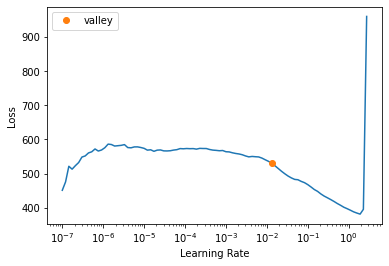

<Figure size 720x720 with 0 Axes>

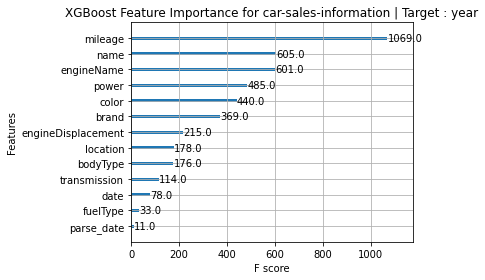

<Figure size 432x288 with 0 Axes>

In [18]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

    feature  importance
0     brand      446.00
1      name      915.00
2  bodyType      247.00
3     color      371.00
4  fuelType       73.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

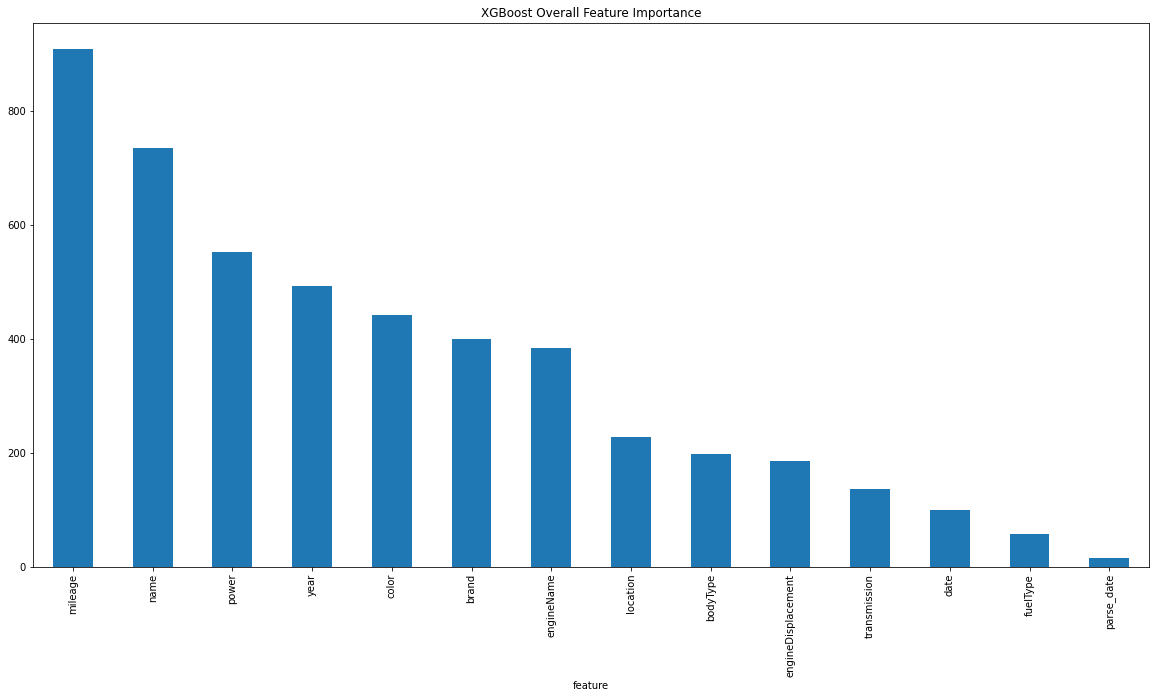

In [19]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [20]:
df.isna().sum()

brand                   0
name                    0
bodyType                0
color                   0
fuelType                0
year                    0
mileage                 0
transmission            0
power                   0
price                   0
vehicleConfiguration    0
engineName              0
engineDisplacement      0
date                    0
location                0
link                    0
parse_date              0
dtype: int64

# **To Be Continued...**